# Make Necessary Imports

In [99]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score

## Unpack Dataset

In [108]:
raw_data = load_breast_cancer()
features = raw_data.data
target = raw_data.target
feature_names = raw_data.feature_names
target_names = raw_data.target_names

print(raw_data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

## Organize the data in a dataframe

In [7]:
df = pd.DataFrame(
    data = features,
    columns = feature_names
)
df['target'] = target
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


# Data Preprocessing

In [144]:
df.shape

(569, 31)

### Check for Null Values

In [141]:
df.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

## Split into Training and Testing Sets

In [8]:
X = df.drop(['target'], axis = 1)
y = df['target']

# y.value_counts(normalize = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = .2,
                                                   stratify = y,
                                                   random_state = 365)

# Using KNNs

## Perform Cross Validation

In [9]:
params = {
    'n_neighbors': np.arange(1, 21),
    'metric': ['euclidean', 'manhattan']
}

In [10]:
cv = GridSearchCV(KNeighborsClassifier(),
                  param_grid = params,
                  scoring = 'accuracy'
                 )

cv.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             scoring='accuracy')

## Initialize Model

In [11]:
knn = cv.best_estimator_
knn

KNeighborsClassifier(metric='manhattan', n_neighbors=8)

## Make Predictions

In [12]:
y_test_pred = knn.predict(X_test)
y_test_pred

array([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1])

## Model Evaluation

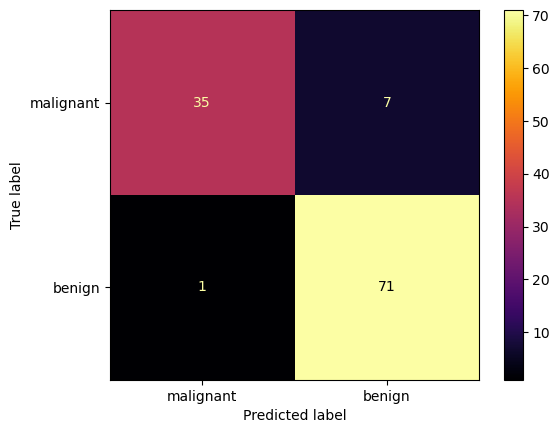

In [13]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    cmap = 'inferno',
    display_labels = target_names
)

In [14]:
print(classification_report(
    y_test,
    y_test_pred,
    target_names = target_names
))

              precision    recall  f1-score   support

   malignant       0.97      0.83      0.90        42
      benign       0.91      0.99      0.95        72

    accuracy                           0.93       114
   macro avg       0.94      0.91      0.92       114
weighted avg       0.93      0.93      0.93       114



In [15]:
print(accuracy_score(
    y_test,
    y_test_pred
))

0.9298245614035088


# Using Decision Trees

## Perform Cross Validation

In [68]:
dtc_params = {
    'ccp_alpha': [0.1, 0.01, 0.001, 0.0001]
}

In [81]:
dtc_cv = GridSearchCV(DecisionTreeClassifier(),
                      param_grid = dtc_params,
                      scoring = 'accuracy'
                      )

dtc_cv.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001, 0.0001]},
             scoring='accuracy')

In [82]:
dtc = dtc_cv.best_estimator_

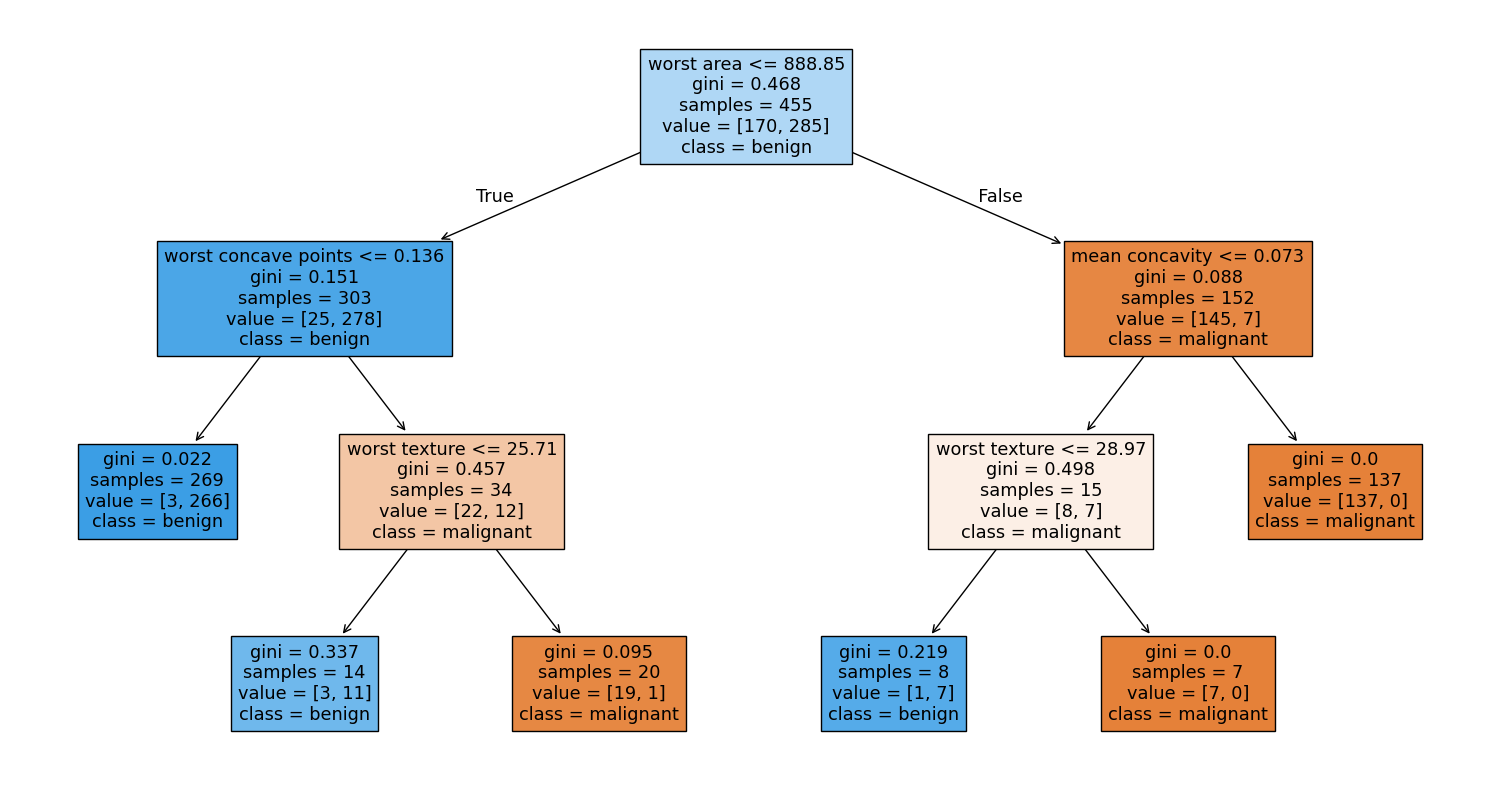

In [83]:
plt.figure(figsize = (19, 10))

plot_tree(dtc, feature_names = feature_names, class_names = target_names, filled=True)

plt.show()

In [90]:
dtc_y_test_pred = dtc.predict(X_test)
# dtc_y_test_pred

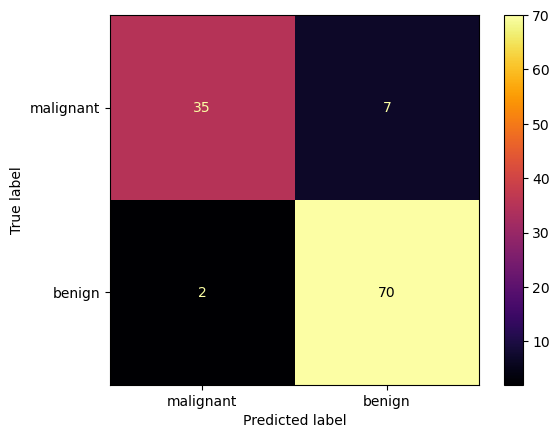

In [85]:
dtc_matrix = ConfusionMatrixDisplay.from_predictions(
    y_test,
    dtc_y_test_pred,
    display_labels = target_names,
    cmap = 'inferno'
)

In [86]:
print(classification_report(
    y_test,
    dtc_y_test_pred,
    target_names = target_names
))

              precision    recall  f1-score   support

   malignant       0.95      0.83      0.89        42
      benign       0.91      0.97      0.94        72

    accuracy                           0.92       114
   macro avg       0.93      0.90      0.91       114
weighted avg       0.92      0.92      0.92       114



In [87]:
print(accuracy_score(
    y_test,
    dtc_y_test_pred
))

0.9210526315789473


# Using RandomForest

## Performing GridSearch

In [133]:
params = {
    'n_estimators': np.arange(1, 21, 1),
    'max_depth': np.arange(1, 21, 1),
}

In [134]:
rf_cv = GridSearchCV(RandomForestClassifier(),
                     param_grid=params,
                     scoring='accuracy',
                     )

rf_cv.fit(X_train, y_train)

C:\Users\harri\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                         'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             scoring='accuracy')

In [135]:
# rf_clf = RandomForestClassifier()
# rf_clf.fit(X_train, y_train)
rf_clf = rf_cv.best_estimator_

In [136]:
rf_y_test_pred = rf_clf.predict(X_test)

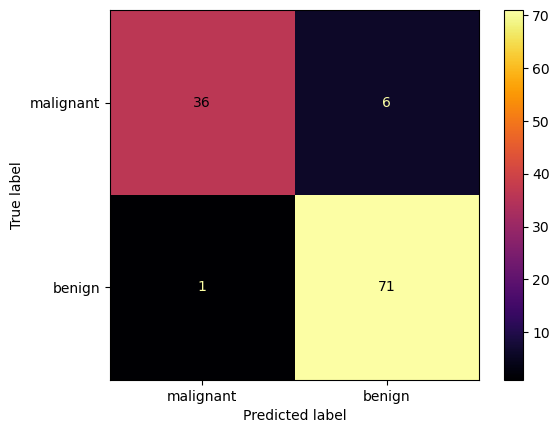

In [137]:
rf_matrix = ConfusionMatrixDisplay.from_predictions(
    y_test,
    rf_y_test_pred,
    display_labels = target_names,
    cmap = 'inferno'
)

In [138]:
print(classification_report(
    y_test,
    rf_y_test_pred,
    target_names=target_names
))

              precision    recall  f1-score   support

   malignant       0.97      0.86      0.91        42
      benign       0.92      0.99      0.95        72

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114



In [139]:
print(accuracy_score(
    y_test,
    rf_y_test_pred
))

0.9385964912280702


Using a Random Forest Model yields an accuracy of ~96%

This is the best so far

# Using Gaussian Naive Bayes

In [ ]:
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)

GaussianNB()

In [101]:
gnb_y_test_pred = gnb_clf.predict(X_test)

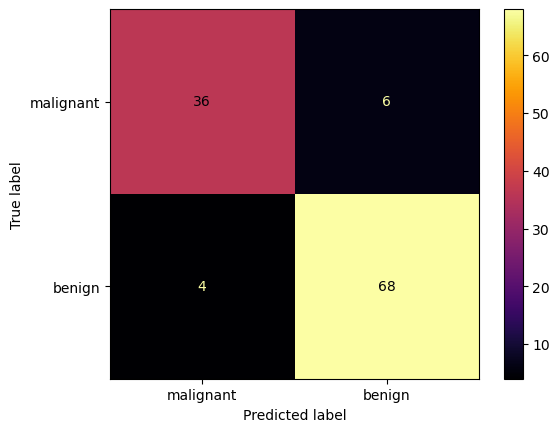

In [102]:
gnb_matrix = ConfusionMatrixDisplay.from_predictions(
    y_test,
    gnb_y_test_pred,
    display_labels = target_names,
    cmap = 'inferno'
)

In [104]:
print(classification_report(
    y_test,
    gnb_y_test_pred,
    target_names=target_names
))

              precision    recall  f1-score   support

   malignant       0.90      0.86      0.88        42
      benign       0.92      0.94      0.93        72

    accuracy                           0.91       114
   macro avg       0.91      0.90      0.90       114
weighted avg       0.91      0.91      0.91       114



In [103]:
print(accuracy_score(
    y_test,
    gnb_y_test_pred
))

0.9122807017543859
